# Hierarchical Window Clustering Approach to detecting Spiking Motifs 

### Sparse method

Develop adaptive thresholding

## Data Generation

In [131]:
'''
Model parameters
'''
import random
import numpy as np
from tqdm import tqdm
import pandas as pd

M = 1 # Number of Spiking motifs
N = 5 # Number of input neurons
D = 70 # temporal depth of receptive field
T = 1500
dt = 1
nrn_fr = 20 # hz
pg_fr = 20 # hz
background_noise_fr = 25 # h


np.random.seed(0)

In [247]:
params = {'M': 4, 'N': 60, 'D': 30, 'T': 1000, 'nrn_fr': 10, 'pg_fr': 4, 'background_noise_fr': 1}
M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params.values()

In [133]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [134]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.rand(N,D,M)*1000
nrn_frs = np.zeros((M))
for m in range(M):
    nrn_frs[m] = np.random.poisson(nrn_fr)
    K_dense[:,:,m] = (K_dense[:,:,m] < nrn_frs[m]).astype('int')
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)


# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.rand(M,T)*1000
pg_frs = np.zeros((M))
for m in range(M):
    pg_frs[m] = np.random.poisson(pg_fr)
    B_dense[m,:] = (B_dense[m,:] < pg_frs[m]).astype('int')
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.rand(N,T+D)*1000
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]
    
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1

In [135]:
print(f'pg_frs: {pg_frs}, nrn_frs: {nrn_frs}')

pg_frs: [7. 7. 8. 4.], nrn_frs: [13. 13. 15. 10.]


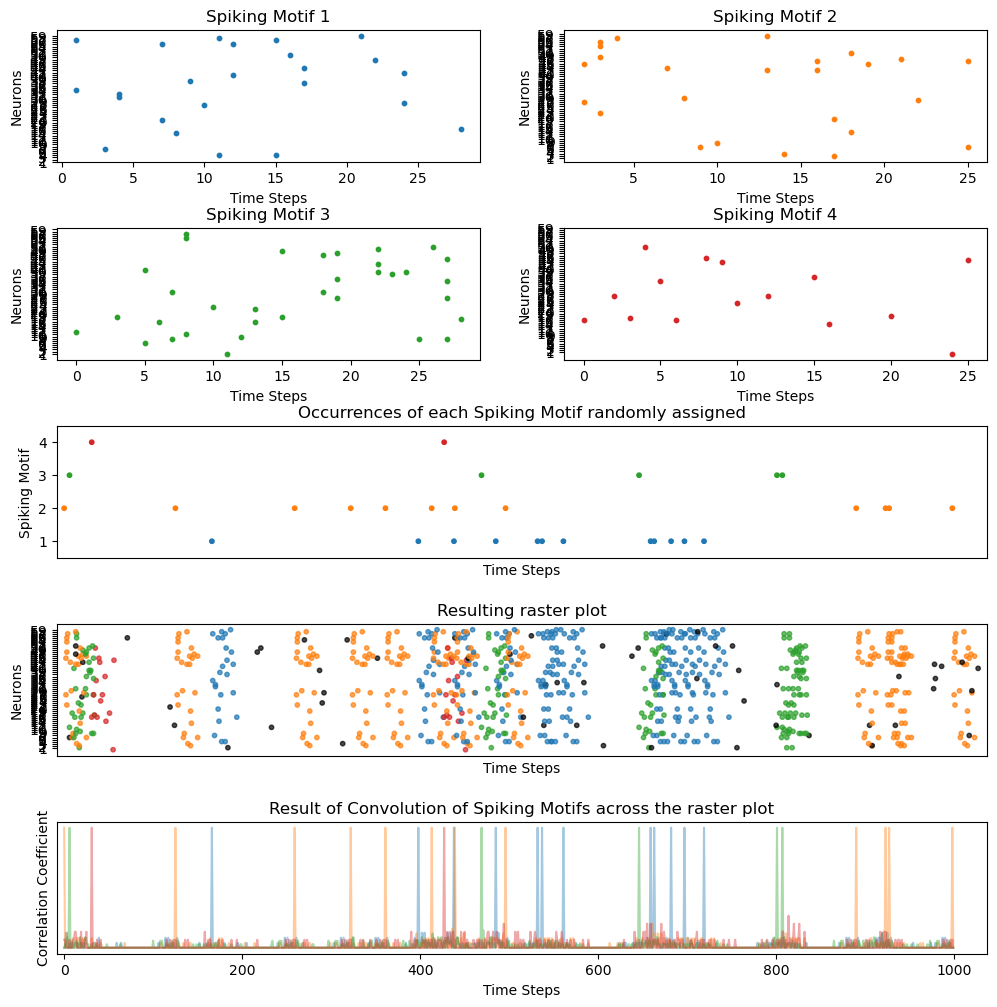

In [136]:
import matplotlib.ticker as ticker

fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

s = 10

# Scatter plots for A, B, C, D
for i, k in enumerate(['A', 'B', 'C', 'D']):
    ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
    ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
    ax[k].set_xlabel('Time Steps')
    ax[k].set_ylabel('Neurons')
    ax[k].set_yticks(range(1, N))

spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
ax['E'].set_xlabel('Time Steps')
ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

# Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


# Scatter plot for F
ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.7, s=s*4, marker='.')
ax['F'].set_title('Resulting raster plot')
ax['F'].set_xlabel('Time Steps')
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

sanity_check = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        sanity_check[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

# Plot for G
[ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

# Set common x-axis from 0 to 1000 with padding
common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
padding = 10
ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

# Share x-axis for E, F, and G
ax['E'].sharex(ax['F'])
ax['G'].sharex(ax['F'])

# Hide x-axis ticks and labels for E and F
ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


This is the generated dataset that we will be working with. The lower panel shows the convolution of the the "Spiking Motifs" with the full raster plot. This convolution shows that by knowing the shape of the spiking motifs, the patterns can be robustly detected.

In [137]:
A_dense = None

In [130]:
import HDP_detect
pattern_template, sublist_keys_filt = HDP_detect.scan_raster(A_sparse[1],A_sparse[0])

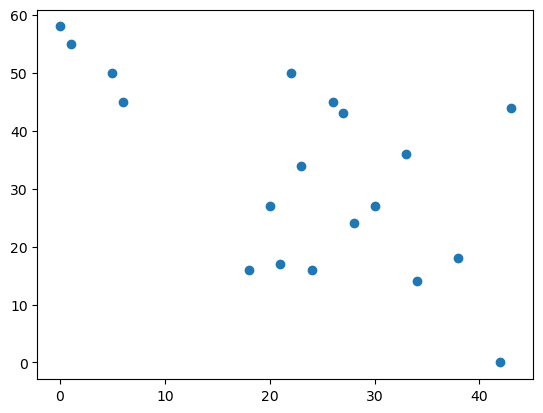

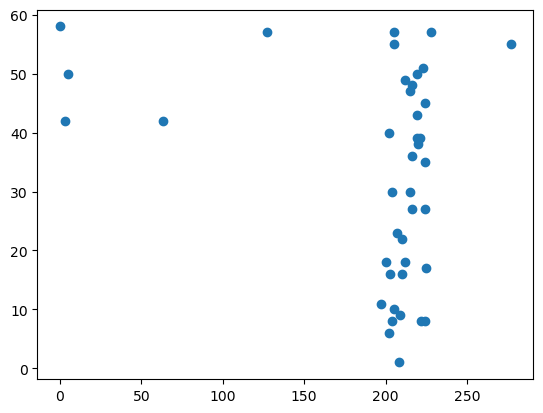

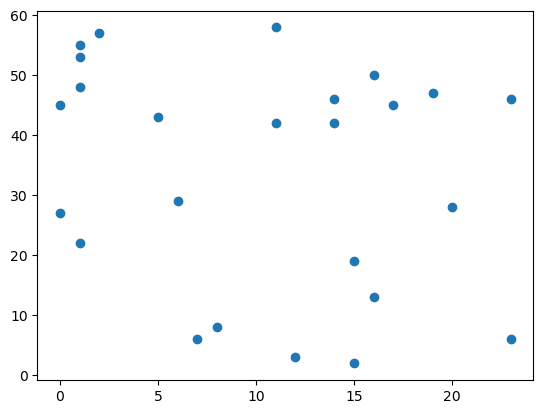

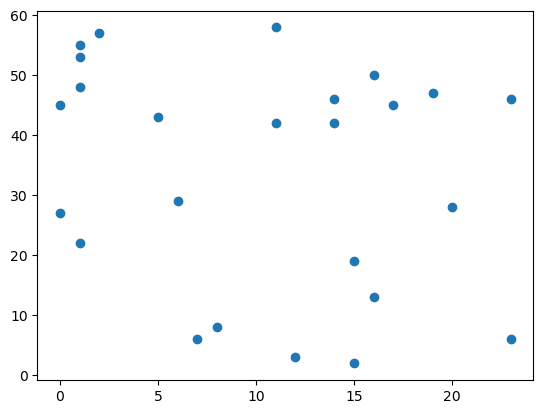

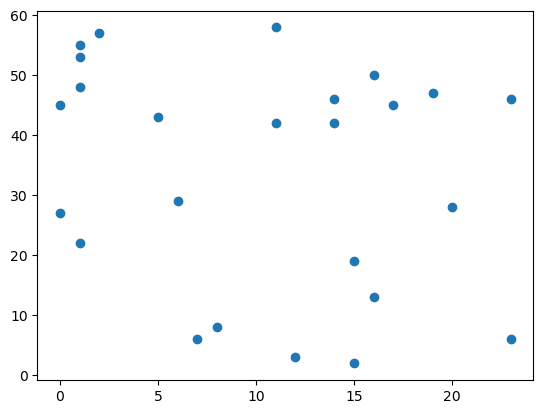

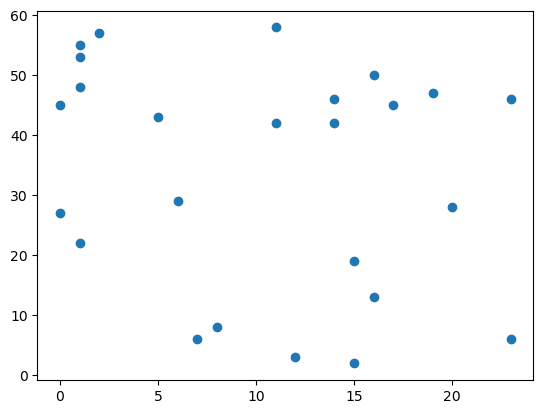

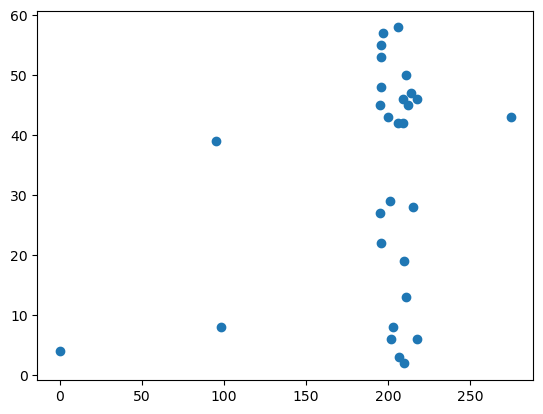

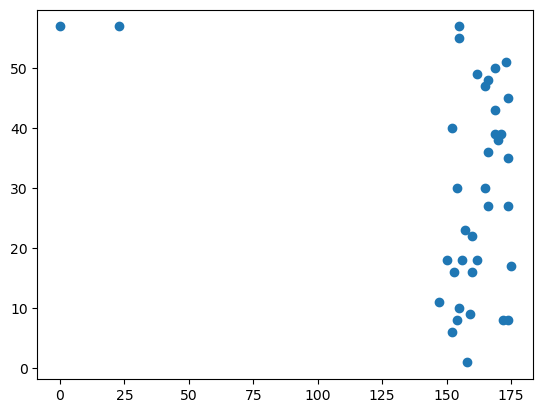

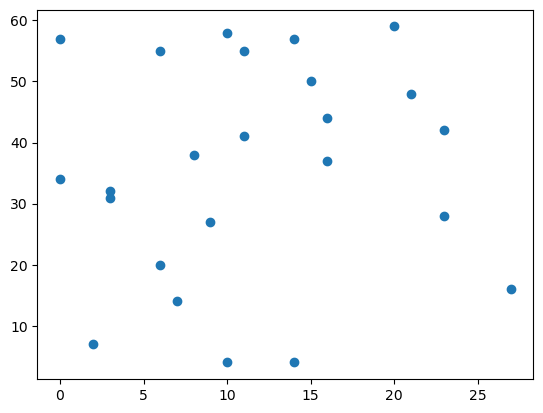

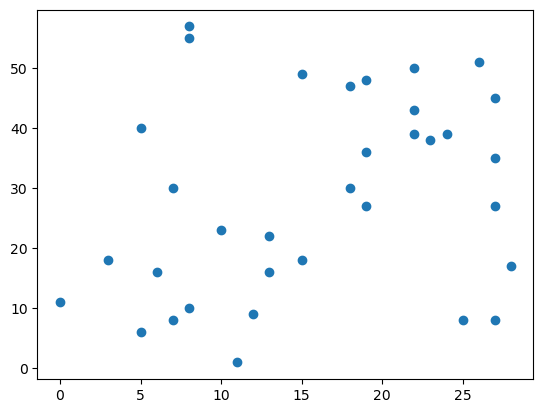

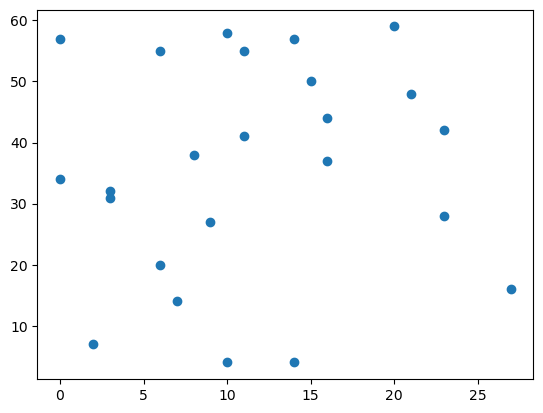

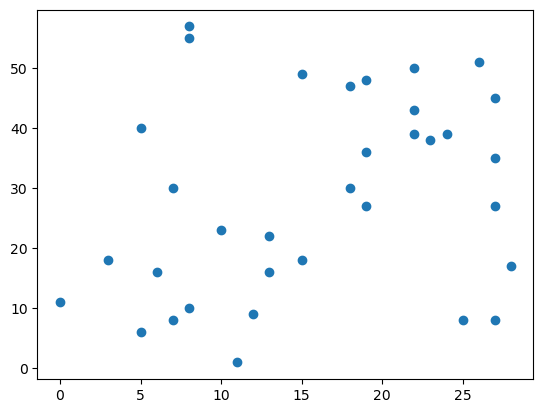

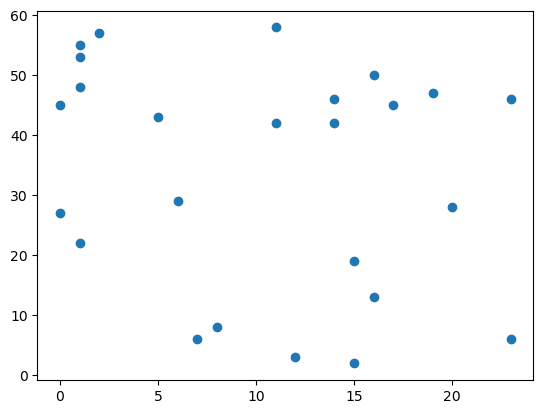

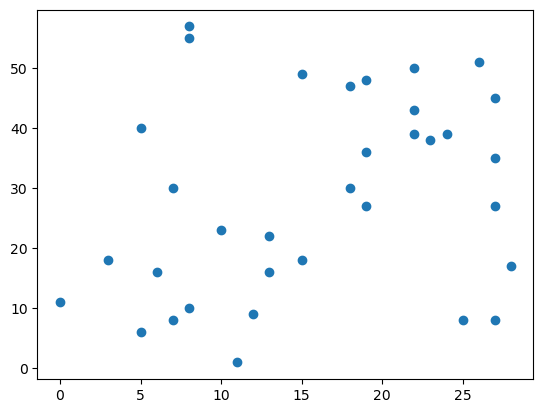

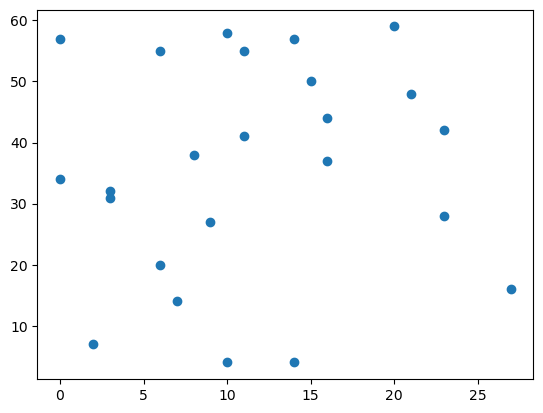

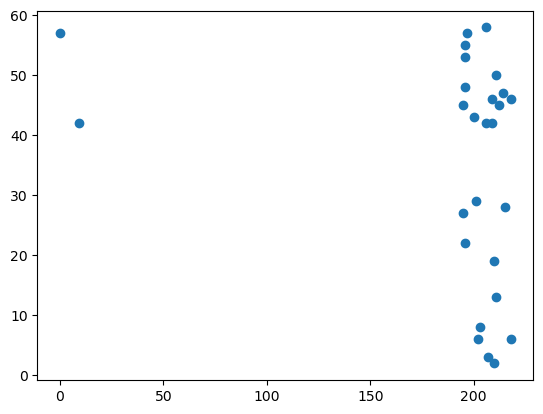

In [38]:
for pattern in pattern_template:
    plt.figure()
    plt.scatter(*pattern.T)
    plt.show()

## Clustering 1 sparse

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Windowing the data
window_dim = 10*int(np.ceil(D/2))  # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
N_labels = A_sparse[0].copy()
T_labels = A_sparse[1].copy()
M_labels = A_sparse[2].copy()

T_labels = np.round(T_labels).astype(int)
T_labels, N_labels,M_labels = pd.DataFrame(np.array([T_labels,N_labels,M_labels])).T.drop_duplicates(subset=[0,1]).to_numpy().T
N=max(N_labels)+1

windows = np.zeros((len(T_labels)),dtype='object')
for i,window_time in enumerate(T_labels):
    condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
    window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
    window =  {tuple(row) for row in  window}
    windows[i] = window

# Set the cutoff value for clustering
cutoff = 0.0

In [186]:
def cluster_windows(cutoff):
    HDPs = []
    sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
    
    # Get the cluster assignments for each spike based on hierarchical clustering
    clusters = np.zeros_like(T_labels)
    for n in range(N):
        idc = np.where(N_labels==n)[0]
        windows_n = windows[idc]
        if len(windows_n) > 1:
            x = np.zeros((len(windows_n),len(windows_n)))
            for i in range(windows_n.shape[0]):
                for j in range(windows_n.shape[0]):
                    common_rows = windows_n[i].intersection(windows_n[j])
                    num_identical_rows = len(common_rows)
                    x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
            np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
            sim_mats[n] = x-1 
            dissimilarity = x-1
            if not np.all(dissimilarity == 0):
                HDPs.append(linkage(dissimilarity, method='complete'))
                l = max(clusters)+1
                clusters[idc]= l+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance')
        
        
#             y = sim_mats[n]
#             fig = plt.figure(figsize=(25, 9))
#             HDP = linkage(y, method='complete')
#             dn = dendrogram(HDP)
#             plt.show()
  
    
    return clusters


In [ ]:
'''
time differences are the isi's filtered by cluster label, they're the unique time signature of each cluster
next, i use a Counter to count how many clusters exhibit each unique time signature
then, I create a list of all of the time signatures that are shared by more than one cluster.
That is what sublist_keys_filt is. 
list(sublist_counts.values()) is the total number of clusters that share a time signature for each time signature


'''

In [220]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
    str_temp = str(temp)
    time_differences.append(temp)
    if str_temp in cluster_sq.keys():
        cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
    else:
        cluster_sq[str_temp] = [cluster]
        
    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    sq_counts = np.zeros(len(sublist_counts)) 
    for i,sublist in enumerate(unique_sublists):
        count = sublist_counts[tuple(sublist)]
        sq_counts[i] = count
    #     print(f"{sublist}: {count} occurrences")
    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    sublist_values_filt = np.array(list(sublist_counts.values()))[np.array(list(sublist_counts.values())) >1]


In [221]:
def check_seq(clusters, cutoff):

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
        str_temp = str(temp)
        time_differences.append(temp)
        if str_temp in cluster_sq.keys():
            cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
        else:
            cluster_sq[str_temp] = [cluster]

    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    sq_counts = np.zeros(len(sublist_counts)) 
    for i,sublist in enumerate(unique_sublists):
        count = sublist_counts[tuple(sublist)]
        sq_counts[i] = count
    #     print(f"{sublist}: {count} occurrences")
    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    
    return cluster_sq, sq_counts, sublist_keys_filt

In [222]:
def check_seq_simple(cluster,cutoff):
    time_differences = []
    for cluster in np.unique(clusters):
        temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
        time_differences.append(temp)

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)
    
    
    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    sublist_values_filt = np.array(list(sublist_counts.values()))[np.array(list(sublist_counts.values())) >1]
    
    return sublist_keys_filt, sublist_values_filt

In [213]:
from collections import Counter
max_iter = 50
x = np.arange(0,100)
fun = lambda x,c : x**(1+c)/10**(2*c+1)
list_cutoffs = 0.01 + np.concatenate(((np.arange(0,100)/100)[:15], np.round(fun(x,.8),2)[10:25],np.round(fun(x,.8),2)[25::4],[10]))
    
num_time_sig_filt = np.zeros((max_iter)) # number of sequences: sequences appear across more than one neuron at least more than one time (num sequences)
max_len_time_sig_filt = np.zeros((max_iter)) # number of repetitions for the sequences that repeated the most times (max reps)
max_num_clu_in_time_sig_filt = np.zeros((max_iter))

for i,cutoff in tqdm(enumerate(list_cutoffs)):
    clusters = cluster_windows(cutoff)
#     cluster_sq, sq_counts, sublist_keys_filt = check_seq(clusters, cutoff)
    sublist_keys_filt, sublist_values_filt = check_seq_simple(clusters, cutoff)
    
    num_time_sig_filt[i] = len(sublist_values_filt)
    if num_time_sig_filt[i] != 0:
        max_len_time_sig_filt[i] = np.max([len(k) for k in sublist_keys_filt])
        max_num_clu_in_time_sig_filt[i] = np.max(sublist_values_filt)
        
#     print(sq_counts)
#     print([len(k) for k in sublist_keys_filt])
    

50it [00:11,  4.43it/s]


In [214]:
np.set_printoptions(suppress=True)


In [216]:
list_cutoffs

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.17,  0.2 ,  0.23,
        0.26,  0.3 ,  0.34,  0.38,  0.42,  0.47,  0.51,  0.56,  0.61,
        0.67,  0.72,  0.78,  0.83,  1.09,  1.37,  1.68,  2.02,  2.39,
        2.78,  3.2 ,  3.65,  4.12,  4.62,  5.14,  5.69,  6.26,  6.85,
        7.47,  8.12,  8.79,  9.48, 10.01])

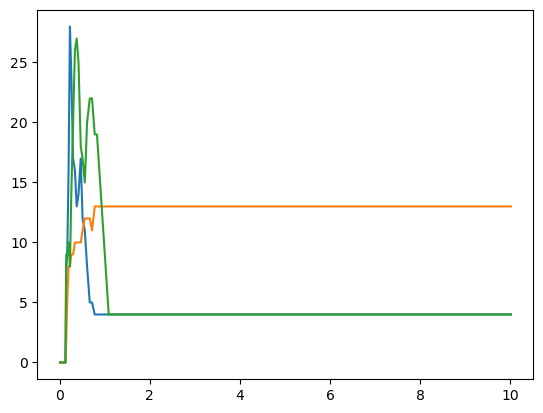

In [218]:
plt.figure()
plt.plot(list_cutoffs, num_time_sig_filt)
plt.plot(list_cutoffs, max_len_time_sig_filt)
plt.plot(list_cutoffs, max_num_clu_in_time_sig_filt)
plt.show()

In [168]:
i = 0
cutoff= 100000
clusters = cluster_windows(cutoff)
cluster_sq, sq_counts, sublist_keys_filt = check_seq(clusters, cutoff)

num_seq[i] = len(sublist_keys_filt)
if num_seq[i] != 0:
    max_seq_rep[i] = np.max([len(k) for k in sublist_keys_filt])

In [169]:
num_seq[0]

4.0

In [162]:
num_seq

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        3.,  9.,  9., 16., 28., 24., 17., 16., 13., 14., 17., 12., 11.,
        8.,  5.,  5.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.])

In [28]:
np.array(pattern_template).shape

(1, 7, 2)

In [35]:
np.array(pattern_template)

array([[[  0,   2],
        [ 47,   1],
        [ 96,   4],
        [185,   0],
        [186,   2],
        [243,   0],
        [495,   2]]], dtype=int64)

In [44]:
pattern_template

[array([[  0,   2],
        [ 47,   1],
        [ 96,   4],
        [185,   0],
        [186,   2],
        [243,   0],
        [495,   2]], dtype=int64)]

In [53]:
np.transpose(pattern_img,axes=[1,2,0]).shape

(5, 496, 1)

In [43]:
K_dense.shape

(5, 70, 1)

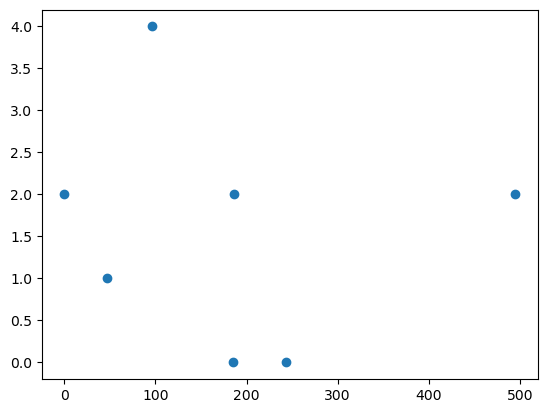

In [42]:
plt.figure()
plt.scatter(pattern_template[0].T[0],pattern_template[0].T[1])
plt.show()

In [41]:
pattern_template[0].T

array([[  0,  47,  96, 185, 186, 243, 495],
       [  2,   1,   4,   0,   2,   0,   2]], dtype=int64)

In [230]:
from collections import Counter

cutoff = 0
lr = 0.01

max_iter=50
lr = 0.01
iter_ = 0

opt_cutoff = cutoff
max_seq_rep = 0


max_iter = 50
x = np.arange(0,100)
fun = lambda x,c : x**(1+c)/10**(2*c+1)
list_cutoffs = 0.01 + np.concatenate(((np.arange(0,100)/100)[:15], np.round(fun(x,.8),2)[10:25],np.round(fun(x,.8),2)[25::4],[10]))
    
max_seq_rep = 0 # number of repetitions for the sequences that repeated the most times (max reps)

for i,cutoff in enumerate(list_cutoffs):
    clusters = cluster_windows(cutoff)
    cluster_sq, sq_counts, sublist_keys_filt = check_seq(clusters, cutoff)
    
    if len(sublist_keys_filt) != 0:
        max_ = np.max([len(k) for k in sublist_keys_filt])
        if max_seq_rep < max_:
            max_seq_rep = max_
            opt_cutoff=cutoff
                    
    print(f'iter - {iter_/max_iter} | cutoff - {cutoff} | opt_cutoff - {opt_cutoff} | most_detections - {max_seq_rep}',end='\r')

clusters = cluster_windows(opt_cutoff)
cluster_sq, sq_counts, sublist_keys_filt = check_seq(clusters, opt_cutoff)

1it [00:00,  4.46it/s]

2it [00:00,  4.16it/s]

3it [00:00,  4.29it/s]

4it [00:00,  4.35it/s]

5it [00:01,  4.13it/s]

6it [00:01,  4.10it/s]

7it [00:01,  4.06it/s]

8it [00:01,  4.07it/s]

9it [00:02,  4.01it/s]

10it [00:02,  4.09it/s]

11it [00:02,  4.06it/s]

12it [00:02,  4.12it/s]

13it [00:03,  4.12it/s]

14it [00:03,  3.99it/s]

15it [00:03,  4.03it/s]

16it [00:03,  4.08it/s]

17it [00:04,  4.11it/s]

18it [00:04,  4.16it/s]

19it [00:04,  4.20it/s]

20it [00:04,  4.25it/s]

21it [00:05,  4.20it/s]

22it [00:05,  4.28it/s]

23it [00:05,  4.22it/s]

24it [00:05,  4.24it/s]

25it [00:06,  4.18it/s]

26it [00:06,  4.23it/s]

27it [00:06,  4.29it/s]

28it [00:06,  4.32it/s]

29it [00:06,  4.35it/s]

30it [00:07,  4.40it/s]

31it [00:07,  4.48it/s]

32it [00:07,  4.52it/s]

33it [00:07,  4.58it/s]

35it [00:08,  4.65it/s]

36it [00:08,  4.72it/s]

37it [00:08,  4.60it/s]

38it [00:08,  4.57it/s]

39it [00:09,  4.38it/s]

40it [00:09,  4.31it/s]

42it [00:09,  4.51it/s]

43it [00:10,  4.54it/s]

44it [00:10,  4.50it/s]

46it [00:10,  4.51it/s]

47it [00:10,  4.48it/s]

49it [00:11,  4.67it/s]

50it [00:11,  4.34it/s]

In [231]:
opt_cutoff

0.78

In [232]:

''' to visualize the clusters'''

recovered_labels = np.zeros_like(clusters)
for l, key in enumerate(sublist_keys_filt):
    for k in cluster_sq[str(key)]:
        recovered_labels[clusters == k] = l+1

''' to get the timings'''

# Sort y according to x
sorted_indices = np.argsort(T_labels)
sorted_x = T_labels[sorted_indices]

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)
    
    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)

pattern_template = []
patterns = []
for i in range(len(all_times)):
    pattern = []
    pattern_template.append([])
    for time in all_times[i]:
        condition = (T_labels > time-window_dim) & (T_labels < time + window_dim)
        pattern = [tuple(k) for k in np.array([T_labels[condition]-time, N_labels[condition]]).T] # creating a list of tuples
        pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
        patterns.append(pattern)


In [233]:
pattern_template = []
patterns = []
for i in range(len(all_times)):
    pattern = []
    pattern_template.append([])
    for time in all_times[i]:
        condition = (T_labels > time-window_dim) & (T_labels < time + window_dim)
        pattern = [tuple(k) for k in np.array([T_labels[condition]-time, N_labels[condition]]).T] # creating a list of tuples
        pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
        patterns.append(pattern)

In [234]:
for i,pattern in enumerate(pattern_template):
    counts = [pattern.count(k) for k in pattern]
    pattern_template[i] = np.array(pattern)[np.where(counts == np.max(counts))[0]]
    pattern_template[i][:,0] -= min(pattern_template[i][:,0])
    pattern_template[i] = np.unique(pattern_template[i],axis=0)



In [235]:
win_size = (N,1+max([max(k[:,0]) for k in pattern_template]))
pattern_img = np.zeros((len(pattern_template),*win_size))
for p,pattern in enumerate(pattern_template):
    for (i,j) in pattern:
        pattern_img[p,j,i] = 1
    

We are left with pattern template candidates. There could be several copies of the same pattern template. 
There could be overlapping pattern templates that vary by n pixels. There could even be more patterns than initialized if
a noisy spike occurs at just the right time.
One approach (and the one that so far results in the best performance) is to correlate each pattern and re-cluster the templates.




In [236]:
from scipy.signal import correlate

matrix_x = pattern_img
matrix_y = pattern_img

# Calculate cross-correlation matrix
cross_corr_matrix = np.zeros((matrix_x.shape[0], matrix_y.shape[0]))

for x_channel_idx in range(matrix_x.shape[0]):
    for y_channel_idx in range(matrix_x.shape[0]):
        if x_channel_idx != y_channel_idx:
            cross_corr = correlate(matrix_x[x_channel_idx,...], matrix_x[y_channel_idx,...], mode='full')
            max_corr = np.max(cross_corr)/ np.sum(matrix_x[x_channel_idx])
            cross_corr_matrix[x_channel_idx, y_channel_idx] = max_corr

dissimilarity = cross_corr_matrix-1

In [237]:
dissimilarity

array([[-1.        , -0.88      , -0.96      , -0.88      ],
       [-0.91176471, -1.        , -0.97058824, -0.91176471],
       [-0.5       , -0.5       , -1.        ,  0.        ],
       [-0.875     , -0.875     , -0.91666667, -1.        ]])

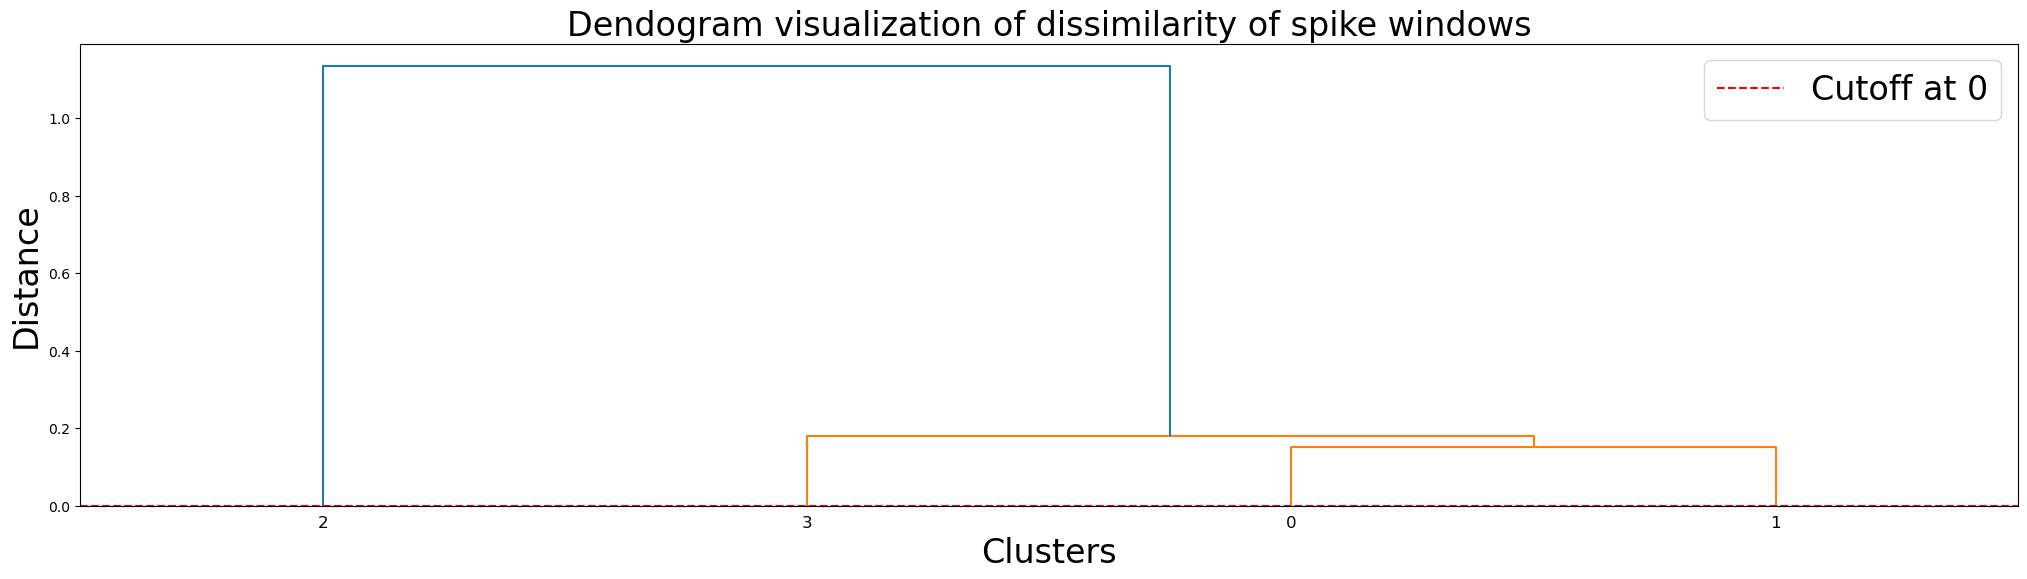

In [238]:
if dissimilarity.shape[0] >1:
    # Create the dendrogram plot
    fig = plt.figure(figsize=(25, 6))
    HDP = linkage(dissimilarity, method='complete')
    dn = dendrogram(HDP)

    # Add a horizontal line at the cutoff value of 1
    plt.axhline(y=0, color='r', linestyle='--', label='Cutoff at 0')

    # Add labels and legend
    plt.title("Dendogram visualization of dissimilarity of spike windows", fontsize=24)
    plt.ylabel('Distance', fontsize=24)
    plt.xlabel('Clusters', fontsize=24)
    plt.legend(fontsize=24)

    plt.show()

In [239]:
raster_size = (N,max(T_labels)+1)
raster = np.zeros((raster_size))
for (i,j) in zip(T_labels,N_labels):
    raster[j,i] =1
    

In [240]:
cutoff = 0
if dissimilarity.shape[0] >1:
    method1_labels = fcluster(HDP,cutoff, criterion='distance')
else:
    method1_labels = [1]

pattern_convolutions = np.zeros((pattern_img.shape[0], raster.shape[1]+pattern_img.shape[2]-1))
for j in range(pattern_img.shape[0]):
    for i in range(pattern_img.shape[1]):
        pattern_convolutions[j] += correlate(raster[i,:], pattern_img[j,i,:], mode='full')
    pattern_convolutions[j] /= np.sum(pattern_img[j,:,:]) # normalize the convolution
    
detected_patterns = pattern_convolutions.copy()
detected_patterns[detected_patterns != 1] = 0
detected_patterns = np.sum(detected_patterns,axis=1)

method1_pattern_winners = []
for l in np.unique(method1_labels):
    idc = np.where(method1_labels==l)[0]
    temp = detected_patterns[method1_labels==l]
    method1_pattern_winners.append(idc[temp == max(temp)][0])
    
method1_pattern_template = pattern_img[method1_pattern_winners]
method1_pattern_template.shape

print('Method 1 detected patterns:', method1_pattern_winners)

Method 1 detected patterns: [0, 1, 3, 2]


Once the patterns are clustered, a pattern "winner" from each cluster is chosen based on how many patterns it detects. Pattern templates that detect more patterns are assumed to be "better" than it's competitors within the same clsuter labe. 
method1_pattern_winners shows the indices of the patterns winners that emerge.

[]

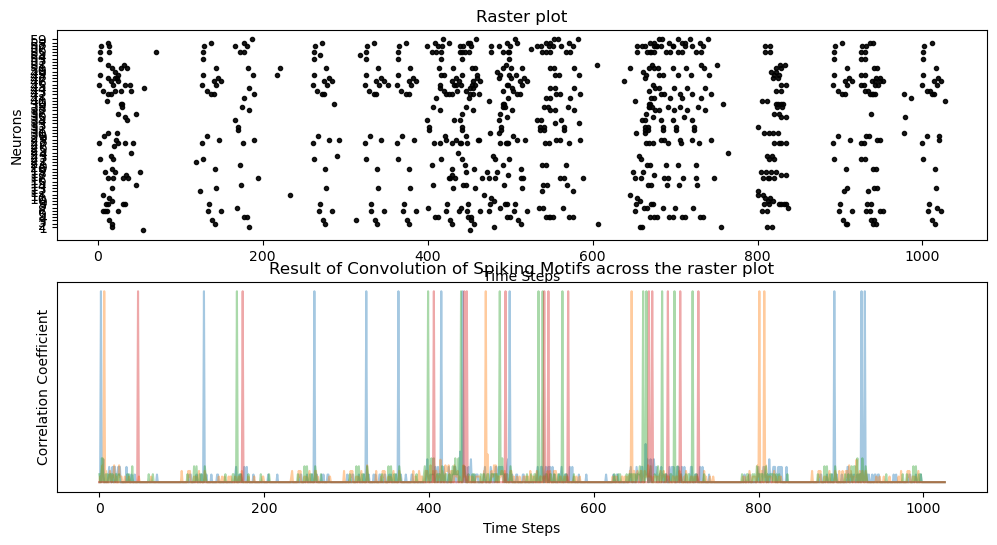

In [241]:
fig,ax = plt.subplot_mosaic('F;G',figsize=(12,6))


# Scatter plot for F
ax['F'].scatter(T_labels, N_labels, alpha=0.9, c='black', marker='.');
ax['F'].set_title('Raster plot');
ax['F'].set_xlabel('Time Steps');
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons


T=max(T_labels)
M = len(method1_pattern_winners)
D = method1_pattern_template.shape[2]

sanity_check = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        if raster[:,i:i+D].shape[1] == D:
            sanity_check[i,j] = np.sum(method1_pattern_template[j,...]*raster[:,i:i+D])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])
    

# Plot for G
[ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

## Performance - Comparing Detected STM's

In [242]:
def get_acc(matrix_x,matrix_y):
    from scipy.signal import correlate
    # Calculate cross-correlation matrix
    cross_corr_matrix = np.zeros((matrix_x.shape[2], matrix_y.shape[2]))

    for x_channel_idx in range(matrix_x.shape[2]):
        for y_channel_idx in range(matrix_y.shape[2]):
            cross_corr = np.zeros((matrix_x.shape[1]+matrix_y.shape[1]-1))
            for n in range(matrix_x.shape[0]):
                cross_corr += correlate(matrix_x[n, :, x_channel_idx], matrix_y[n, :, y_channel_idx], mode='full')
            max_corr = np.max(cross_corr) / max(np.sum(matrix_x[...,x_channel_idx]),np.sum(matrix_y[...,y_channel_idx]))
            cross_corr_matrix[x_channel_idx, y_channel_idx] = max_corr
#     print(cross_corr_matrix)
#     print( np.sum(matrix_x[...,x_channel_idx]))
    SM_acc_m1 = np.max(cross_corr_matrix,axis=1)
    return SM_acc_m1, cross_corr_matrix

In [243]:
matrix_x = K_dense
matrix_y = method1_pattern_template
matrix_y = np.transpose(matrix_y,[1,2,0])

SM_acc_m1, cc_1 = get_acc(matrix_x,matrix_y)

In [244]:
SM_acc_m1, cc_1

(array([1.        , 1.        , 1.        , 0.13333333]),
 array([[0.08      , 0.02941176, 1.        , 0.08333333],
        [1.        , 0.05882353, 0.08      , 0.        ],
        [0.05882353, 1.        , 0.02941176, 0.        ],
        [0.04      , 0.05882353, 0.08333333, 0.13333333]]))

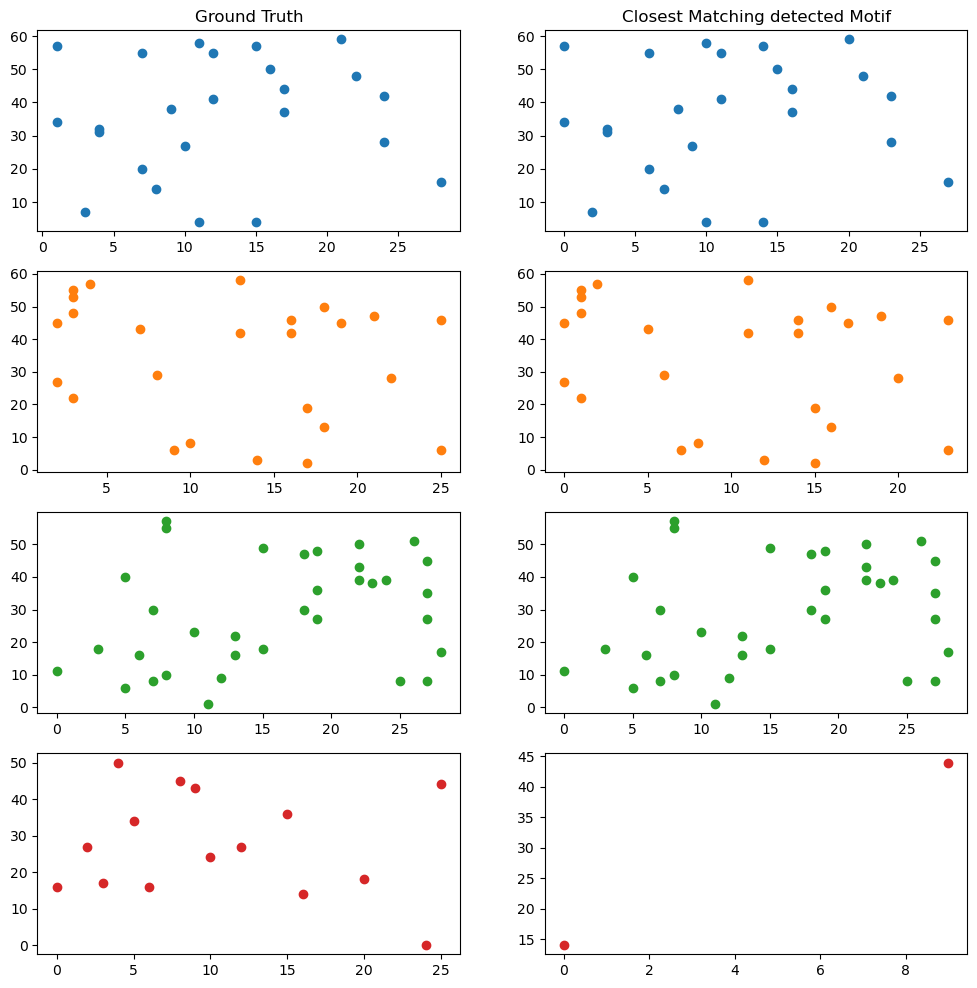

In [245]:
motif_map = (np.arange(0,M),np.argmax(cc_1,axis=1))
motif_map
fig,ax = plt.subplots(len(motif_map[0]),len(motif_map),figsize=(12,M*3))
for i,(a,b) in enumerate(zip(motif_map[0],motif_map[1])):
    ax[i,0].scatter(np.where(K_dense[...,a])[1],np.where(K_dense[...,a])[0],c=palette[i+1])
    ax[i,1].scatter(np.where(method1_pattern_template[b])[1],np.where(method1_pattern_template[b])[0],c=palette[i+1])

ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Closest Matching detected Motif')
plt.show()

In [246]:
print('Method 1, average SM_accuracy: ', sum(SM_acc_m1)/M)
print('Method 1, SM_accuracy: ', SM_acc_m1)

Method 1, average SM_accuracy:  0.7833333333333333
Method 1, SM_accuracy:  [1.         1.         1.         0.13333333]
